In [1]:
import gc
import math
import pickle
import random
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Initial Data Load
Load in all of the subject IDs, Assignments, and CodeStateIDs. Also load in the grades and scores for each of the subjects and code states. 

In [3]:
# Load final exam and assignment data
data = pd.DataFrame(columns=['SubjectID', 'Assignment', 'CodeStateID'])
grades = {}
scores = {}
total_non_compile = 0
data_dir = Path.cwd() / 'data'
for directory in [data_dir / 'F19_All' / 'Train', data_dir / 'S19_All']:
    grade_data = pd.read_csv(directory / 'Data' / 'LinkTables' / 'Subject.csv')
    for row in grade_data.itertuples():
        grades[row.SubjectID] = row._2 if directory.name == 'S19_All' else row._2 / 100
    main = pd.read_csv(directory / 'Data' / 'MainTable.csv')
    total_non_compile += len(main['CodeStateID'].unique())
    for row in main[main['EventType'] == 'Run.Program'].itertuples():
        scores[row.CodeStateID] = row.Score
    main['Assignment'] = [f'{int(x[0])}-{int(x[1])}' for x in list(zip(main['AssignmentID'], main['ProblemID']))]
    data = pd.concat([data, main[['SubjectID', 'Assignment', 'CodeStateID']]], ignore_index=True)

data['Score'] = [scores[x] for x in data['CodeStateID']]
data['ExamGrade'] = [grades[x] if x in grades else 0 for x in data['SubjectID']]
data.head()

print(f'ALL Programs: {total_non_compile}')

ALL Programs: 161378


In [4]:
# Find the Code IDs for the submissions with the highest score for each student for each assignment
students = list(data['SubjectID'].unique())
assignments = data['Assignment'].unique()
best_score_data = {}
num_null_submissions = 0
for student in students:
    best_ids = [None] * len(assignments)
    s_filter = data[data['SubjectID'] == student]
    a_idx = 0
    for assignment in assignments:
        a_filter = s_filter[s_filter['Assignment'] == assignment].reset_index()
        if len(a_filter.index) > 0:
            best_ids[a_idx] = a_filter['CodeStateID'][np.argmax(a_filter['Score'])]
        else:
            num_null_submissions += 1
        a_idx += 1
    best_score_data[student] = best_ids
best_score_data[students[0]][0:5]

print(f"TOTAL Number of submissions: {len(data.index)}")
# Free some memory
del scores
del data
gc.collect()

print(f"Number of Students: {len(students)}")
print(f"Number of student-assignment pairs: {len(students) * len(assignments)}")
print(f"Number of assignment-student pairs with no submissions: {num_null_submissions}")

TOTAL Number of submissions: 463968
Number of Students: 780
Number of student-assignment pairs: 39000
Number of assignment-student pairs with no submissions: 5143


Train avg: 0.59 Test avg: 0.61
Train dev: 0.25 Test dev: 0.23
Train


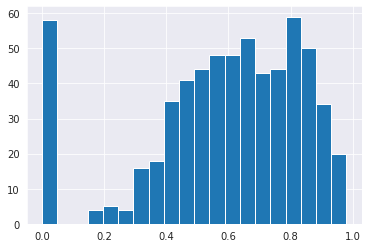

Number of students: 624
Missing Grades: 35
Test


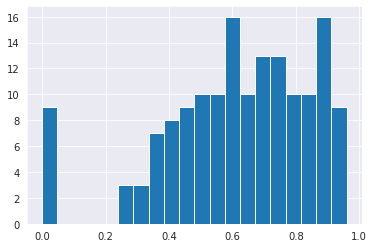

Number of students: 156
Missing Grades: 6


In [5]:
# Divide data into 80% training data, 20% testing data
random.seed(1)
num_students = len(students)
test_students = set(random.sample(students, int(num_students * 0.2)))
train_students = set([x for x in students if x not in test_students])

missing_test_grades = 0
missing_train_grades = 0

test_grades = []
for x in test_students:
    if x in grades:
        test_grades.append(grades[x])
    else:
        test_grades.append(0)
        missing_test_grades += 1

train_grades = []
for x in train_students:
    if x in grades:
        train_grades.append(grades[x])
    else:
        train_grades.append(0)
        missing_train_grades += 1

print(f'Train avg: {np.mean(train_grades):0.2f} Test avg: {np.mean(test_grades):0.2f}')
print(f'Train dev: {np.std(train_grades):0.2f} Test dev: {np.std(test_grades):0.2f}')

# test_ids = set([x in test_students for x in students])
# train_ids = set([x in train_students for x in students])
print('Train')
plt.hist(train_grades, bins=20)
plt.show()
print(f'Number of students: {len(train_students)}')
print(f'Missing Grades: {missing_train_grades}')

print('Test')
plt.hist(test_grades, bins=20)
plt.show()
print(f'Number of students: {len(test_students)}')
print(f'Missing Grades: {missing_test_grades}')

In [6]:
# code_states = {}
# for directory in ['F19_All', 'S19_All']:
#   base_path = os.path.join('data', directory, 'Train' if directory == 'F19_All' else '')
#   code_data = pd.read_csv(os.path.join(base_path, 'Data', 'CodeStates', 'CodeStates.csv'))
#   for row in code_data.itertuples():
#     code_states[row.CodeStateID] = row.Code

In [7]:
# random.seed(1)
# validation_set = set(random.sample(list(code_states.keys()), int(len(code_states) / 10)))
# for c_id in train_data['CodeStateID'].unique():
#   directory = 'Validate' if c_id in validation_set else 'Train' 
#   with open(os.path.join(directory, c_id + '.java'), 'w', encoding="utf-8") as f:
#     print(code_states[c_id], file=f)

In [8]:
# for c_id in test_data['CodeStateID'].unique():
#   with open(os.path.join('Test', c_id + '.java'), 'w', encoding="utf-8") as f:
#     print(code_states[c_id], file=f)

In [9]:
# Given a dataframe, a vector length, and a number of components,
# Divide all the vectors into a train and test set and transform them using PCA with the given number of components
def train_test_vectors(df, vector_length, lstr):
    train_X = []
    train_y = []
    test_X = []
    test_y = []
    vector_lookup = {}
    num_missing = 0
    total_train_sub = 0
    total_test_sub = 0
    for idx, row in df.iterrows():
        vector = np.array(row[0:vector_length])
        vector_lookup[row['CodeStateID'][len(lstr):]] = vector
    for student in students:
        all_assign = []
        num_present = 0
        for x in best_score_data[student]:
            if x in vector_lookup:
                all_assign.append(vector_lookup[x])
                num_present += 1
            else:
                num_missing += 1
                all_assign.append(np.zeros(vector_length))
        all_assign = np.concatenate(all_assign)
        if student in train_students:
            train_X.append(all_assign)
            train_y.append(grades[student] if student in grades else 0)
            total_train_sub += num_present
        elif student in test_students:
            test_X.append(all_assign)
            test_y.append(grades[student] if student in grades else 0)
            total_test_sub += num_present
    #   pca = PCA(n_components=n_components, random_state=1)
    #   train_X = pca.fit_transform(train_X)
    #   test_X = pca.transform(test_X)
    print(f'Missing {num_missing} vectors')
    print(f'Train vectors: {total_train_sub}')
    print(f'Test vectors: {total_test_sub}')
    return train_X, train_y, test_X, test_y

In [10]:
def tune_model(name, model, parameters, n_iter):
    pipeline = Pipeline(steps=[('pca', PCA(random_state=1)), ('model', model)])
    if name in saved_models:
        pipeline.set_params(**saved_models[name])
    else:
        new_params = {'pca__n_components': parameters['n_components']}
        for key in parameters:
            if key != 'n_components':
                new_params['model__' + key] = parameters[key]
        cv = RandomizedSearchCV(pipeline, new_params, random_state=1, scoring='neg_mean_absolute_error', n_iter=n_iter,
                                verbose=2)
        cv.fit(train_X, train_y)
        saved_models[name] = cv.best_params_
        with open('saved_models', 'wb') as f:
            pickle.dump(saved_models, f)
        pipeline.set_params(**cv.best_params_)
    #   print("Variance captured: %0.3f" % np.sum(pipeline.steps[0].explained_variance_ratio_))
    return pipeline

In [11]:
with open('saved_models', 'rb') as f:
    saved_models = pickle.load(f)

In [12]:
models = [
    ('Linear', LinearRegression(), {'n_components': list(range(10, 300, 10))}),
    ('Ridge', Ridge(),
     {'n_components': list(range(10, 300, 10)), 'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 5]}),
    ('Neural', MLPRegressor(max_iter=500, activation='logistic'),
     {'n_components': list(range(10, 300, 10)),
      'hidden_layer_sizes': [(128, 64, 32, 16), (128, 64, 32), (128, 64), (64, 32, 16), (64, 32), (32, 16, 8), (32, 16),
                             (16, 8)],
      'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 5]}),
    ('Lasso', Lasso(),
     {'n_components': list(range(10, 300, 10)), 'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 5]})
]

In [15]:
embedding_vectors = [
    ('code2vec', 384, ''),
    ('deepwalk', 50, ''),
    ('node2vec', 50, '')
]

embedding_methods = ['deepwalk', 'node2vec']
cstrats = [(f'{strat}Canonicalization', '') for strat in ['full', 'none', 'orig', 'part']]
cstrats.extend((f'{strat}C-', f'{strat}C-') for strat in ['F', 'L', 'N', 'V'])
embedding_vectors.extend((f'{strat}{method}', 50, lstr) for method, (strat, lstr) in itertools.product(embedding_methods, cstrats))
embedding_vectors

[('code2vec', 384, ''),
 ('deepwalk', 50, ''),
 ('node2vec', 50, ''),
 ('fullCanonicalizationdeepwalk', 50, ''),
 ('noneCanonicalizationdeepwalk', 50, ''),
 ('origCanonicalizationdeepwalk', 50, ''),
 ('partCanonicalizationdeepwalk', 50, ''),
 ('FC-deepwalk', 50, 'FC-'),
 ('LC-deepwalk', 50, 'LC-'),
 ('NC-deepwalk', 50, 'NC-'),
 ('VC-deepwalk', 50, 'VC-'),
 ('fullCanonicalizationnode2vec', 50, ''),
 ('noneCanonicalizationnode2vec', 50, ''),
 ('origCanonicalizationnode2vec', 50, ''),
 ('partCanonicalizationnode2vec', 50, ''),
 ('FC-node2vec', 50, 'FC-'),
 ('LC-node2vec', 50, 'LC-'),
 ('NC-node2vec', 50, 'NC-'),
 ('VC-node2vec', 50, 'VC-')]

In [16]:
vectors = pd.read_csv(data_dir / 'Vectors' / 'tf_idf.csv')
train_X, train_y, test_X, test_y = train_test_vectors(vectors, 50, '')
dummy = DummyRegressor()
dummy.fit(train_X, train_y)
pred_y = dummy.predict(test_X)
report_data = {'Model': ['Baseline (mean)'], 'Embedding': ['None'], 'MAE': [mean_absolute_error(test_y, pred_y)],
               'RMSE': [math.sqrt(mean_squared_error(test_y, pred_y))]}

Missing 5143 vectors
Train vectors: 26993
Test vectors: 6864


In [18]:
for v_name, v_size, v_lstr in embedding_vectors:
    print(f"Training {v_name} based model now")
    vectors = pd.read_csv(data_dir / 'Vectors' / f'{v_name}.csv')
    train_X, train_y, test_X, test_y = train_test_vectors(vectors, v_size, v_lstr)
    for m_name, model, params in models:
        model = tune_model(v_name + '_' + m_name, model, params, n_iter=50)
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        report_data['Model'].append(m_name + ' Regression')
        report_data['Embedding'].append(v_name)
        report_data['MAE'].append(mean_absolute_error(test_y, pred_y))
        report_data['RMSE'].append(math.sqrt(mean_squared_error(test_y, pred_y)))

Training code2vec based model now
Missing 5314 vectors
Train vectors: 26855
Test vectors: 6831
Training deepwalk based model now
Missing 6017 vectors
Train vectors: 26252
Test vectors: 6731
Training node2vec based model now
Missing 6017 vectors
Train vectors: 26252
Test vectors: 6731
Training fullCanonicalizationdeepwalk based model now
Missing 5267 vectors
Train vectors: 26900
Test vectors: 6833
Training noneCanonicalizationdeepwalk based model now
Missing 5267 vectors
Train vectors: 26900
Test vectors: 6833
Training origCanonicalizationdeepwalk based model now
Missing 5410 vectors
Train vectors: 26788
Test vectors: 6802
Training partCanonicalizationdeepwalk based model now
Missing 5267 vectors
Train vectors: 26900
Test vectors: 6833
Training FC-deepwalk based model now
Missing 6094 vectors
Train vectors: 26185
Test vectors: 6721
Fitting 5 folds for each of 29 candidates, totalling 145 fits


/home/john/.pyenv/versions/3.10.4/envs/cfg2vec/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.6s
[CV] END ...............................pca__n_components=10; total time=   0.7s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.6s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.6s
[CV] END ...............................pca__n_components=20; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.5s
[CV] END ...............................pca__n_components=30; total time=   0.6s
[CV] END ...............................pca__n_components=30; total time=   0.5s
[CV] END ...................

/home/john/.pyenv/versions/3.10.4/envs/cfg2vec/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.6s
[CV] END ...............................pca__n_components=20; total time=   0.9s
[CV] END ...............................pca__n_components=20; total time=   1.0s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.9s
[CV] END ...............................pca__n_components=30; total time=   0.9s
[CV] END ...............................pca__n_components=30; total time=   0.9s
[CV] END ...................

/home/john/.pyenv/versions/3.10.4/envs/cfg2vec/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.7s
[CV] END ...............................pca__n_components=10; total time=   0.6s
[CV] END ...............................pca__n_components=10; total time=   0.7s
[CV] END ...............................pca__n_components=10; total time=   0.6s
[CV] END ...............................pca__n_components=20; total time=   0.8s
[CV] END ...............................pca__n_components=20; total time=   0.8s
[CV] END ...............................pca__n_components=20; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.9s
[CV] END ...............................pca__n_components=20; total time=   1.0s
[CV] END ...............................pca__n_components=30; total time=   0.9s
[CV] END ...............................pca__n_components=30; total time=   1.0s
[CV] END ...................

/home/john/.pyenv/versions/3.10.4/envs/cfg2vec/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.6s
[CV] END ...............................pca__n_components=20; total time=   0.8s
[CV] END ...............................pca__n_components=20; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.9s
[CV] END ...............................pca__n_components=20; total time=   1.0s
[CV] END ...............................pca__n_components=20; total time=   1.1s
[CV] END ...............................pca__n_components=30; total time=   0.9s
[CV] END ...............................pca__n_components=30; total time=   0.9s
[CV] END ...................

/home/john/.pyenv/versions/3.10.4/envs/cfg2vec/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.6s
[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.6s
[CV] END ...............................pca__n_components=20; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=30; total time=   0.5s
[CV] END ...............................pca__n_components=30; total time=   0.8s
[CV] END ...................

/home/john/.pyenv/versions/3.10.4/envs/cfg2vec/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.6s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.6s
[CV] END ...............................pca__n_components=30; total time=   0.6s
[CV] END ...............................pca__n_components=30; total time=   0.6s
[CV] END ...................

/home/john/.pyenv/versions/3.10.4/envs/cfg2vec/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.6s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=30; total time=   0.8s
[CV] END ...............................pca__n_components=30; total time=   0.7s
[CV] END ...................

/home/john/.pyenv/versions/3.10.4/envs/cfg2vec/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.4s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=10; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.6s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=20; total time=   0.5s
[CV] END ...............................pca__n_components=20; total time=   0.7s
[CV] END ...............................pca__n_components=30; total time=   0.8s
[CV] END ...............................pca__n_components=30; total time=   0.7s
[CV] END ...................

In [19]:
pd.DataFrame(report_data)

,Model,Embedding,MAE,RMSE
0,Baseline (mean),None,0.188360,0.235051
1,Linear Regression,code2vec,0.163144,0.207892
2,Ridge Regression,code2vec,0.163144,0.207892
3,Neural Regression,code2vec,0.153871,0.197376
4,Lasso Regression,code2vec,0.156264,0.200568
...,...,...,...,...
72,Lasso Regression,NC-node2vec,0.153923,0.200529
73,Linear Regression,VC-node2vec,0.152711,0.198702
74,Ridge Regression,VC-node2vec,0.151101,0.196304
75,Neural Regression,VC-node2vec,0.152023,0.197489


In [20]:
pd.DataFrame(saved_models).transpose()

,pca__n_components,model__alpha,model__hidden_layer_sizes
code2vec_Linear,90.0,NaN,NaN
code2vec_Ridge,90.0,0.0001,NaN
code2vec_Neural,80,0.1,"(128, 64)"
code2vec_Lasso,150.0,0.01,NaN
deepwalk_Linear,40.0,NaN,NaN
...,...,...,...
NC-node2vec_Lasso,110.0,0.0,NaN
VC-node2vec_Linear,50.0,NaN,NaN
VC-node2vec_Ridge,160.0,5.0,NaN
VC-node2vec_Neural,150,0.000001,"(128, 64)"


In [ ]:
# import pickle
# with open('saved_models', 'wb') as f:
#   pickle.dump({}, f)

In [21]:
rddf = pd.DataFrame(report_data)

print('# Minimum MAE Chosen')
print('## Best Model of each embedding type')
print(rddf.loc[rddf.groupby('Embedding')['MAE'].idxmin()])
print('## Best Model')
print(rddf.loc[rddf['MAE'].idxmin()])
print()
print('Minimum RMSE Chosen')
print(rddf.loc[rddf.groupby('Embedding')['RMSE'].idxmin()].to_csv('min_rmse_models.csv'))
print('## Best Model')
print(rddf.loc[rddf['RMSE'].idxmin()])

# Minimum MAE Chosen
## Best Model of each embedding type
                Model                     Embedding       MAE      RMSE
30   Ridge Regression                   FC-deepwalk  0.151166  0.196892
63  Neural Regression                   FC-node2vec  0.151280  0.195342
36   Lasso Regression                   LC-deepwalk  0.151295  0.196257
66   Ridge Regression                   LC-node2vec  0.152039  0.197264
39  Neural Regression                   NC-deepwalk  0.151846  0.199002
71  Neural Regression                   NC-node2vec  0.151943  0.199105
0     Baseline (mean)                          None  0.188360  0.235051
42   Ridge Regression                   VC-deepwalk  0.149541  0.196023
74   Ridge Regression                   VC-node2vec  0.151101  0.196304
3   Neural Regression                      code2vec  0.153871  0.197376
8    Lasso Regression                      deepwalk  0.153947  0.202952
16   Lasso Regression  fullCanonicalizationdeepwalk  0.143468  0.187325
48   L

In [22]:
def calculate_percent_change(first, second):
    delta = second - first
    return (delta / first) * 100

In [23]:
bmc = rddf.loc[rddf[rddf['Embedding'] == 'code2vec']['MAE'].idxmin()]
brc = rddf.loc[rddf[rddf['Embedding'] == 'code2vec']['RMSE'].idxmin()]

bmm = rddf.loc[rddf['MAE'].idxmin()]
brm = rddf.loc[rddf['RMSE'].idxmin()]
print(calculate_percent_change(bmc['MAE'], bmm['MAE']))
print(calculate_percent_change(brc['RMSE'], brm['RMSE']))

-7.369474783671278
-6.651360234377425


In [24]:
pd.pivot_table(rddf, values='RMSE', index='Model', columns='Embedding').to_csv('rmse_csv.csv')